In [3]:
%pylab inline
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.fir_design_helper as fir_d
import sk_dsp_comm.iir_design_helper as iir_d
import sk_dsp_comm.multirate_helper as mrh
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'sk_dsp_comm'

In [ ]:
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing

# Desain dari Persyaratan Respons Amplitudo

Baik dengan fir_design_helper maupun iir_design_helper, desain dimulai dengan persyaratan respons amplitudo, yaitu frekuensi kritis jalur lewat filter, frekuensi kritis jalur hentian, gelombang berombak jalur lewat, dan penurunan jalur hentian. Jumlah taps/koefisien (kasus FIR) atau urutan filter (kasus IIR) yang diperlukan untuk memenuhi persyaratan ini kemudian ditentukan dan koefisien filter dikembalikan sebagai array b untuk FIR, dan untuk IIR baik array b dan a, dan array sos 2D, dengan baris yang berisi kaskade yang sesuai dari topologi bagian kedua orde untuk filter IIR.

Untuk kasus FIR kita memiliki dalam domain $z$:

$$
    H_\text{FIR}(z) = \sum_{k=0}^N b_k z^{-k}
$$

dengan ndarray b = $[b_0, b_1, \ldots, b_N]$. Untuk kasus IIR kita memiliki dalam domain $z$:

$$\begin{align}
    H_\text{IIR}(z) &= \frac{\sum_{k=0}^M b_k z^{-k}}{\sum_{k=1}^N a_k z^{-k}} \\
    &= \prod_{k=0}^{N_s-1} \frac{b_{k0} + b_{k1} z^{-1} + b_{k2} z^{-2}}{1 + a_{k1} z^{-1} + a_{k2} z^{-2}} = \prod_{k=0}^{N_s-1} H_k(z)
\end{align}$$

di mana $N_s = \lfloor(N+1)/2\rfloor$. Untuk bentuk b/a, koefisien disusun sebagai berikut:

```python
b = [b0, b1, ..., bM-1], the numerator filter coefficients
a = [a0, a1, ..., aN-1], the denominator filter ceofficients
```
Untuk bentuk sos, setiap baris dari array sos 2D sesuai dengan koefisien dari $H_k(z)$, sebagai berikut:

```python
SOS_mat = [[b00, b01, b02, 1, a01, a02], #biquad 0
           [b10, b11, b12, 1, a11, a12], #biquad 1
            .
            .
           [bNs-10, bNs-11, bNs-12, 1, aNs-11, aNs-12]] #biquad Ns-1

# Desain Filter FIR Fasa Linier

Fokus utama dari modul ini adalah menambahkan kemampuan untuk merancang filter FIR fasa linier dari persyaratan respons amplitudo yang ramah pengguna.

Sebagian besar desain filter digital dimotivasi oleh keinginan untuk mendekati filter ideal. Ingatlah bahwa filter ideal akan meneruskan sinyal dari sejumlah frekuensi tertentu dan memblokir yang lain. Baik untuk filter analog maupun digital, perancang dapat memilih dari berbagai teknik pendekatan. Untuk filter digital, teknik pendekatan jatuh ke dalam kategori IIR atau FIR. Dalam desain filter FIR, dua teknik populer adalah memotong respons impuls filter ideal dan menerapkan jendela, serta pendekatan equiripple optimal. Pendekatan berbasis pengambilan sampel frekuensi juga populer, tetapi tidak akan dipertimbangkan di sini, meskipun scipy.signal mendukung ketiganya. Desain filter umumnya dimulai dengan spesifikasi respons frekuensi yang diinginkan. Respons frekuensi filter dapat dinyatakan dalam beberapa cara, tetapi respons amplitudo adalah yang paling umum, misalnya, jelaskan bagaimana $H_c(j\Omega)$ atau $H(e^{j\omega}) = H(e^{j2\pi f/f_s})$ seharusnya berperilaku. Desain yang selesai terdiri dari jumlah koefisien (taps) yang diperlukan dan koefisiennya sendiri (bilangan floating-point presisi ganda atau float64 dalam Numpy, dan float64_t dalam C). Gambar 1, di bawah ini, menunjukkan persyaratan respons amplitudo dalam hal gain filter dan frekuensi kritis untuk filter lowpass, highpass, bandpass, dan bandstop. Frekuensi kritis diberikan di sini dalam hal persyaratan analog dalam Hz. Frekuensi pengambilan sampel diasumsikan dalam Hz. Gelombang berombak jalur lewat dan nilai penurunan jalur hentian dalam dB. Perlu dicatat bahwa dalam dB, penurunan adalah kebalikan dari gain, misalnya, -60 gain jalur hentian setara dengan 60 dB penurunan jalur hentian.|

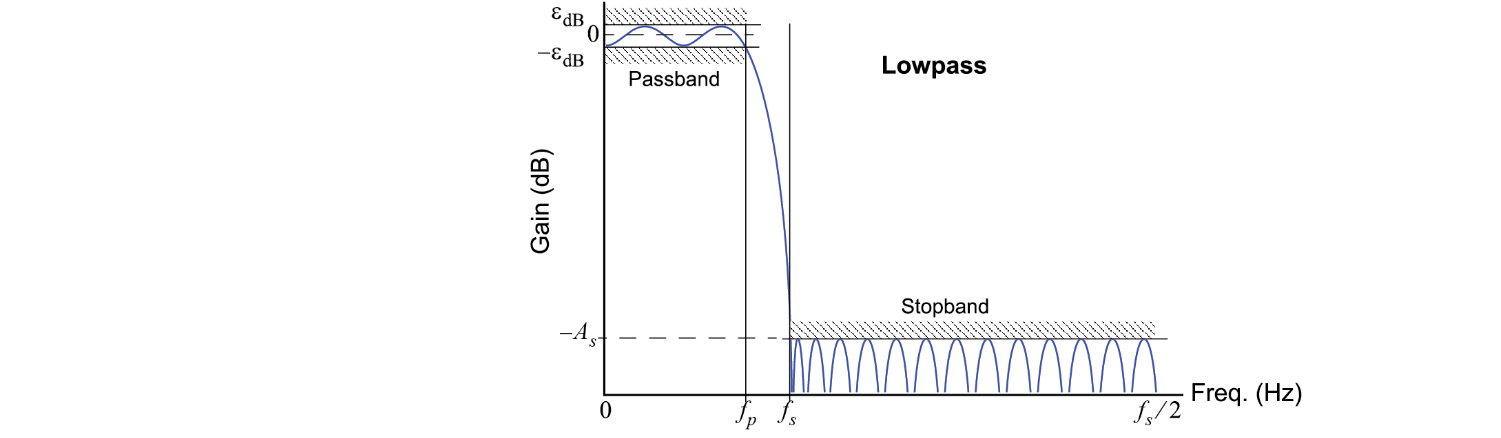

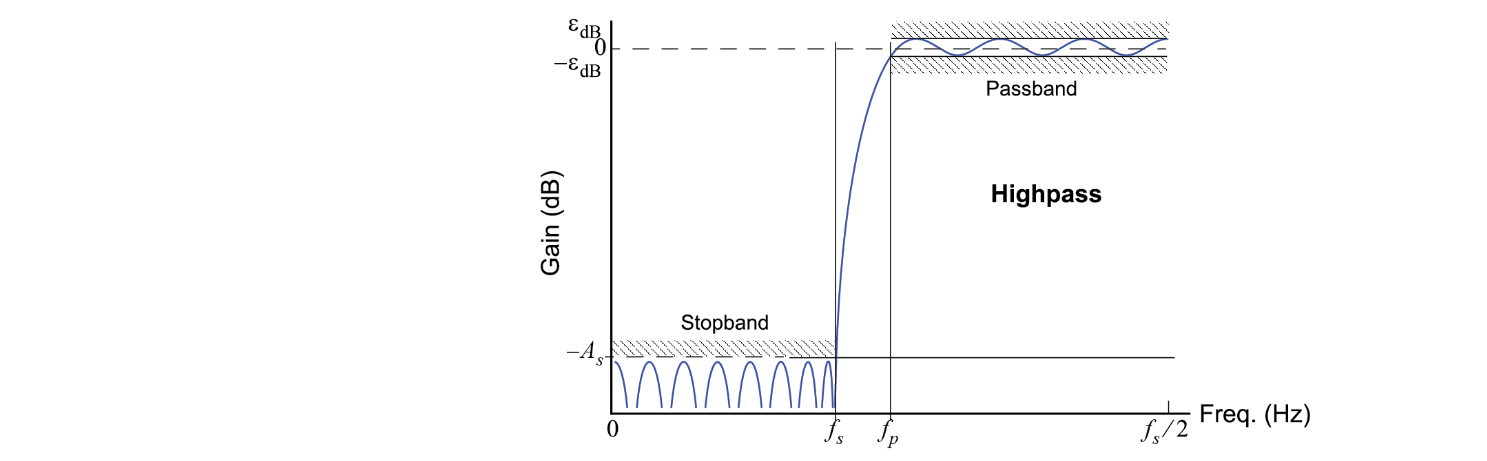

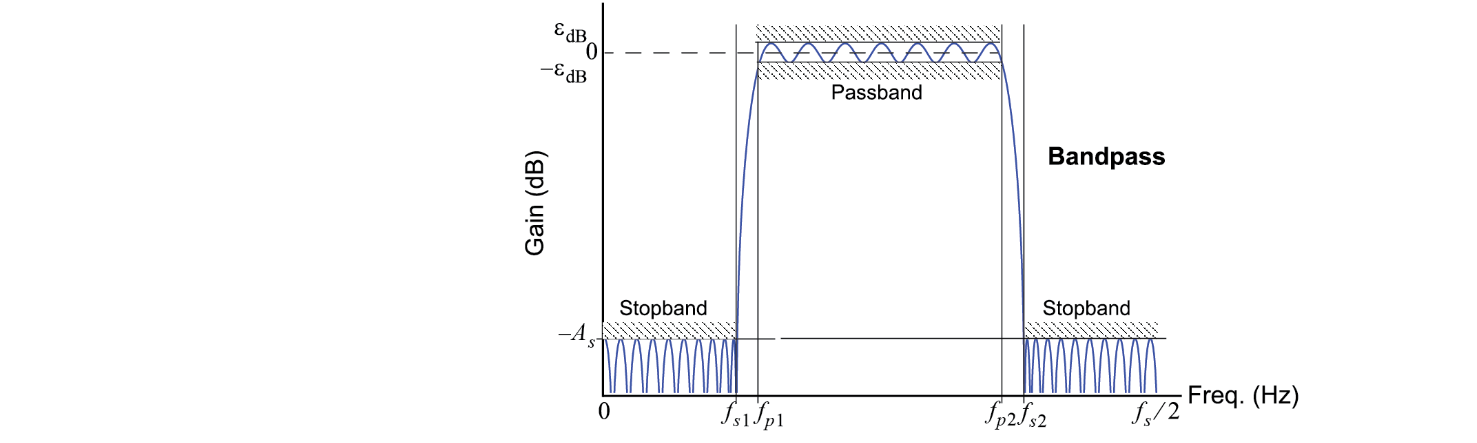

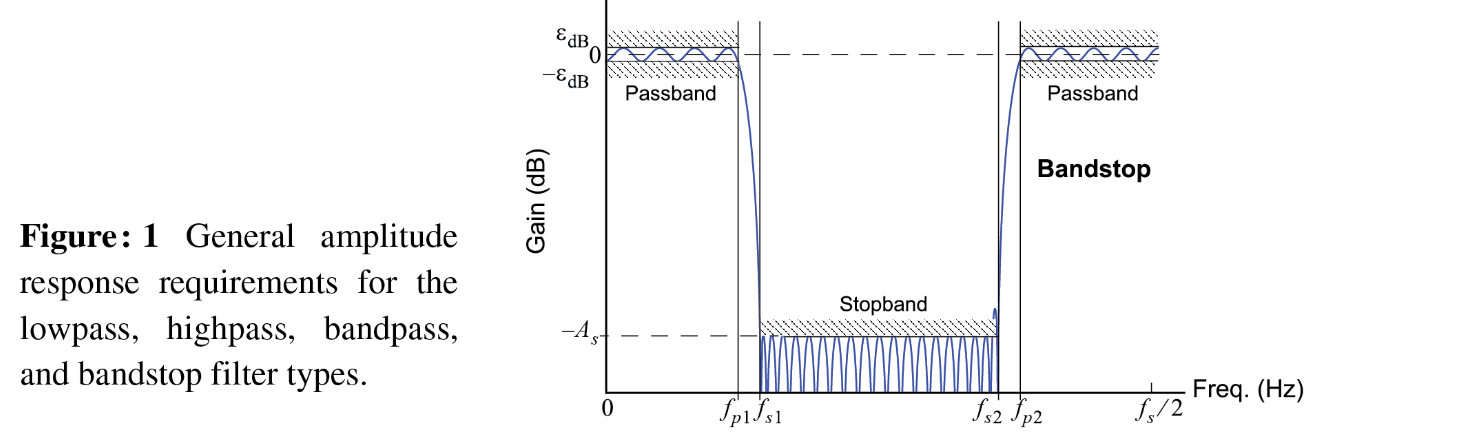

Terdapat 10 fungsi desain filter dan satu fungsi plotting yang tersedia di fir_design_helper.py. Empat fungsi untuk merancang filter FIR berbasis jendela Kaiser dan empat fungsi untuk merancang filter FIR berbasis equiripple. Dari delapan yang baru saja dijelaskan, semuanya menerima persyaratan respons amplitudo dan mengembalikan array koefisien. Dua dari 10 fungsi filter hanyalah pembungkus sekitar fungsi scipy.signal signal.firwin() untuk merancang filter dari urutan tertentu ketika satu (lowpass) atau dua (bandpass) frekuensi kritis diberikan. Fungsi pembungkus ini memperbaiki tipe jendela ke nilai default firwin dari hann (hanning). Delapan lainnya dijelaskan di bawah ini dalam Tabel 1. Fungsi plotting menyediakan cara mudah untuk membandingkan respons frekuensi yang dihasilkan dari satu atau lebih desain dalam satu plot. Mode tampilan memungkinkan gain dalam dB, fase dalam radian, tundaan kelompok dalam sampel, dan tundaan kelompok dalam detik untuk frekuensi pengambilan sampel yang diberikan. Fungsi ini, freq_resp_list(), berfungsi baik untuk desain FIR maupun IIR. Tabel 1 menyediakan detail antarmuka untuk delapan fungsi desain di mana d_stop dan d_pass adalah nilai dB positif dan frekuensi kritis memiliki unit yang sama dengan frekuensi pengambilan sampel $f_s$. Fungsi-fungsi ini tidak membuat hasil yang sempurna sehingga beberapa penyesuaian parameter desain mungkin diperlukan, selain menambah atau mengurangi urutan filter melalui $N_{bump}$.

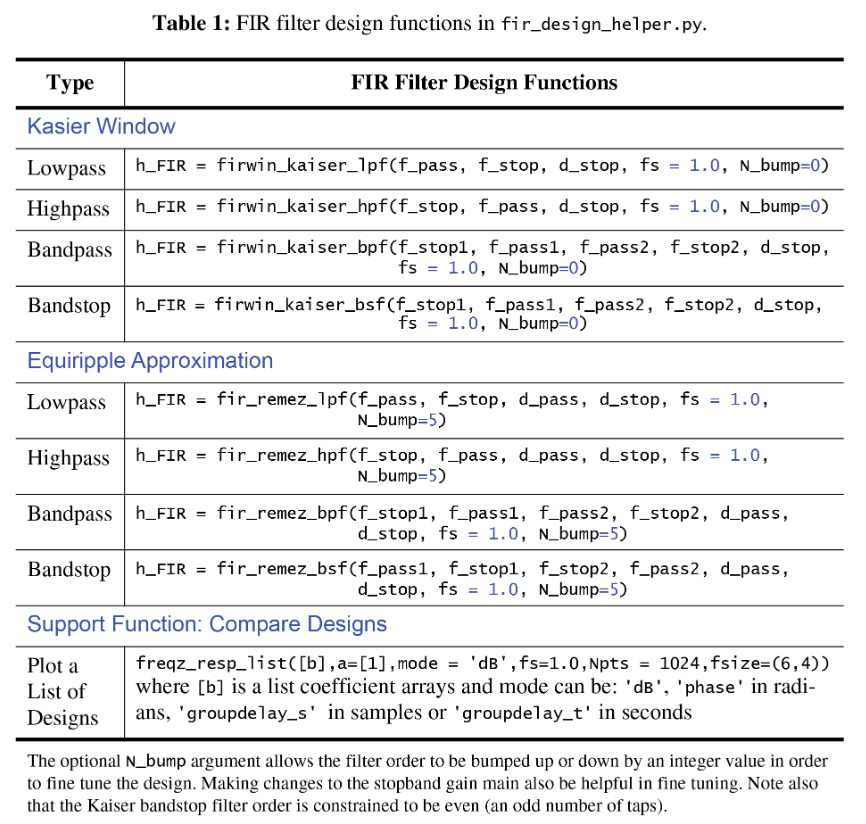

## Design Examples

### Contoh 1: Lowpass dengan $f_s = 1$ Hz
Untuk filter dengan 31 tap ini, kita memilih frekuensi cutoff menjadi $F_c = F_s/8$, atau dalam bentuk terormalisasi $f_c = 1/8$.

In [ ]:
b_k = fir_d.firwin_kaiser_lpf(1/8,1/6,50,1.0)
b_r = fir_d.fir_remez_lpf(1/8,1/6,0.2,50,1.0)

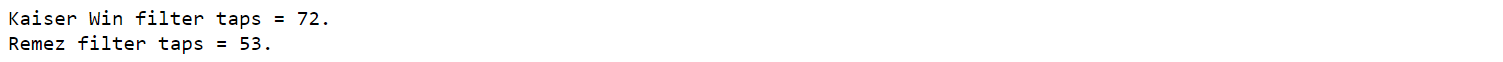

In [ ]:
fir_d.freqz_resp_list([b_k,b_r],[[1],[1]],'dB',fs=1)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Lowpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k),r'Remez: %d taps' % len(b_r)),loc='best')
grid();

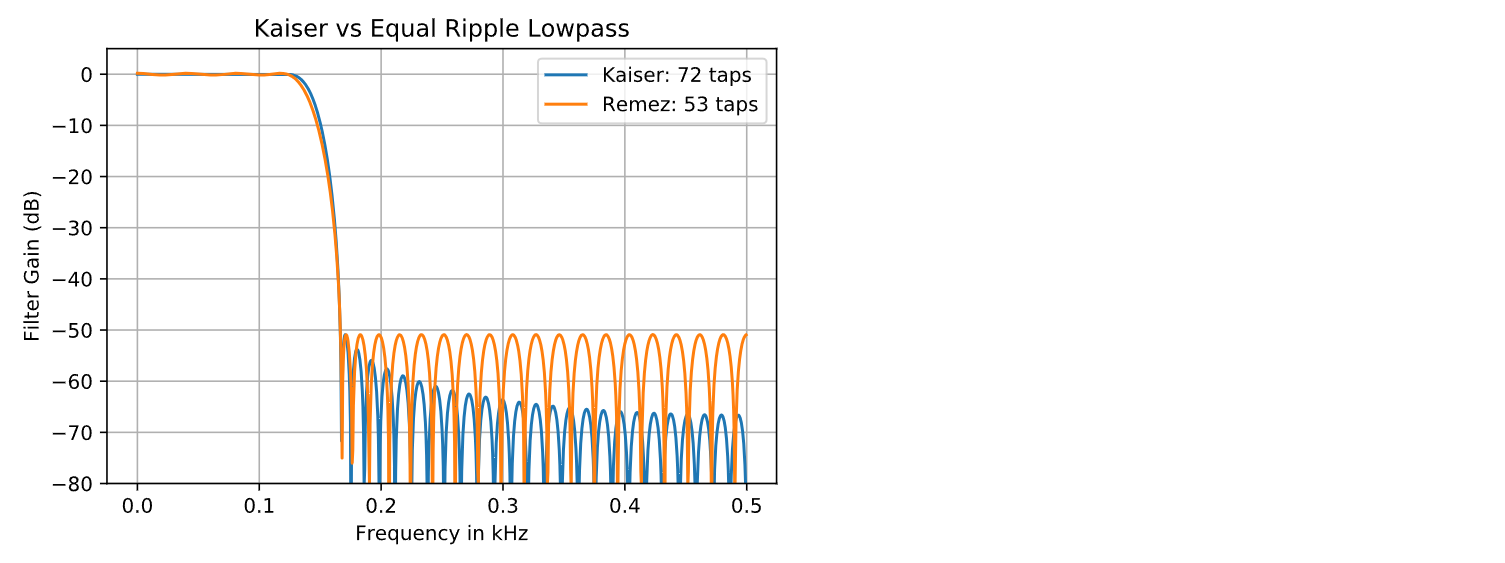

In [ ]:
b_k_hp = fir_d.firwin_kaiser_hpf(1/8,1/6,50,1.0)
b_r_hp = fir_d.fir_remez_hpf(1/8,1/6,0.2,50,1.0)

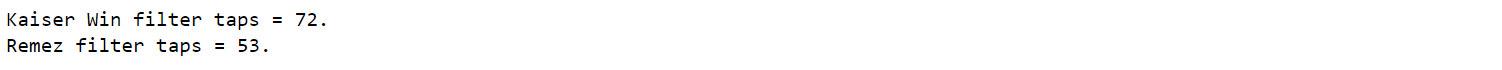

In [ ]:
fir_d.freqz_resp_list([b_k_hp,b_r_hp],[[1],[1]],'dB',fs=1)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Lowpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k),r'Remez: %d taps' % len(b_r)),loc='best')
grid();

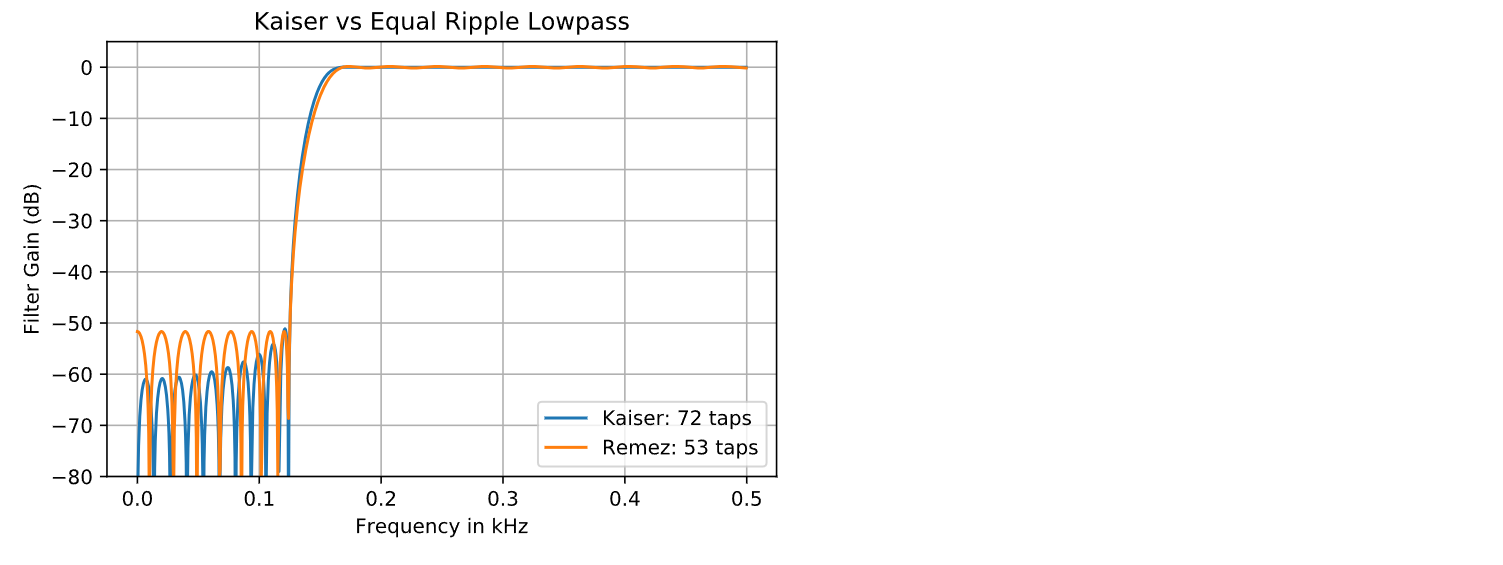

In [ ]:
b_k_bp = fir_d.firwin_kaiser_bpf(7000,8000,14000,15000,50,48000)
b_r_bp = fir_d.fir_remez_bpf(7000,8000,14000,15000,0.2,50,48000)

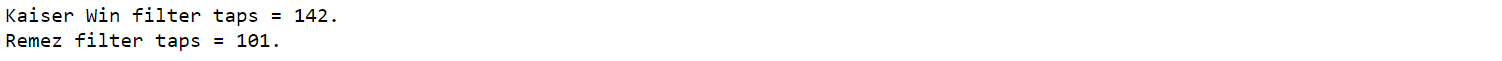

In [ ]:
fir_d.freqz_resp_list([b_k_bp,b_r_bp],[[1],[1]],'dB',fs=48)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Bandpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k_bp),
        r'Remez: %d taps' % len(b_r_bp)),
       loc='lower right')
grid();

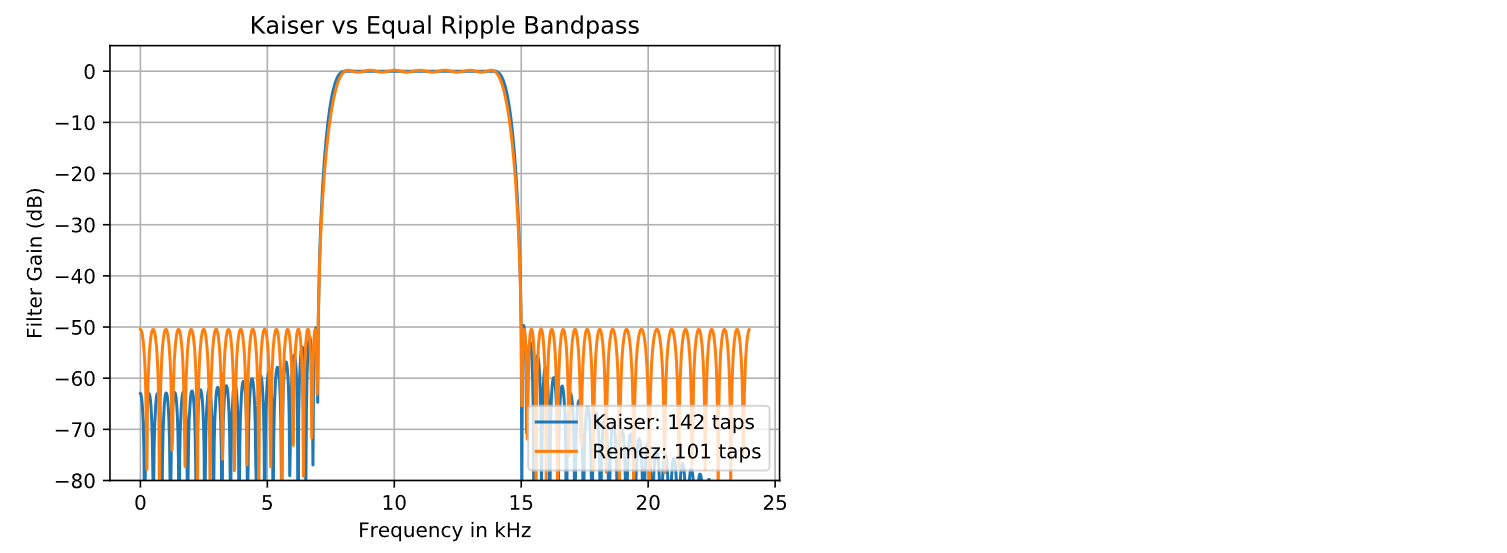

## Contoh Desain yang Berguna untuk Interpolasi atau Desimasi
Di sini kita mempertimbangkan desain lowpass yang perlu melewati frekuensi dari [0, 4000] Hz dengan sampling rate 96000 Hz. Skenario ini muncul saat membangun interpolator menggunakan kelas-kelas modul scikit-dsp-comm multirate_helper.py untuk meningkatkan sampling rate dari 8000 Hz menjadi 96000 Hz, atau faktor interpolasi sebesar $L = 12$. Perhatikan di bagian atas notebook ini kita juga memiliki impor

```python
import sk_dsp_comm.multirate_helper as mrh`
```

sehingga beberapa fungsionalitas dapat diakses. Untuk lebih detail tentang penggunaan multirate_helper

Mulailah dengan desain equalripple yang memiliki transition band yang terpusat pada 4000 Hz dengan ripple passband sebesar 0.5 dB dan attenuasi stopband sebesar 60 dB.0 rh

In [ ]:
b_up = fir_d.fir_remez_lpf(3300,4300,0.5,60,96000)

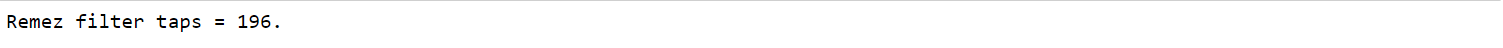

In [ ]:
mr_up = mrh.multirate_FIR(b_up)

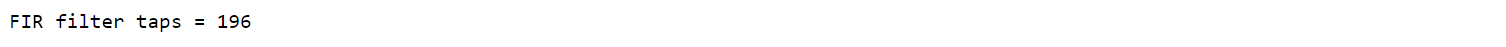

* Pertimbangkan konfigurasi pole-zero untuk filter berorde tinggi ini.

In [ ]:
# Take a look at the pole-zero configuration of this very
# high-order (many taps) linear phase FIR
mr_up.zplane()

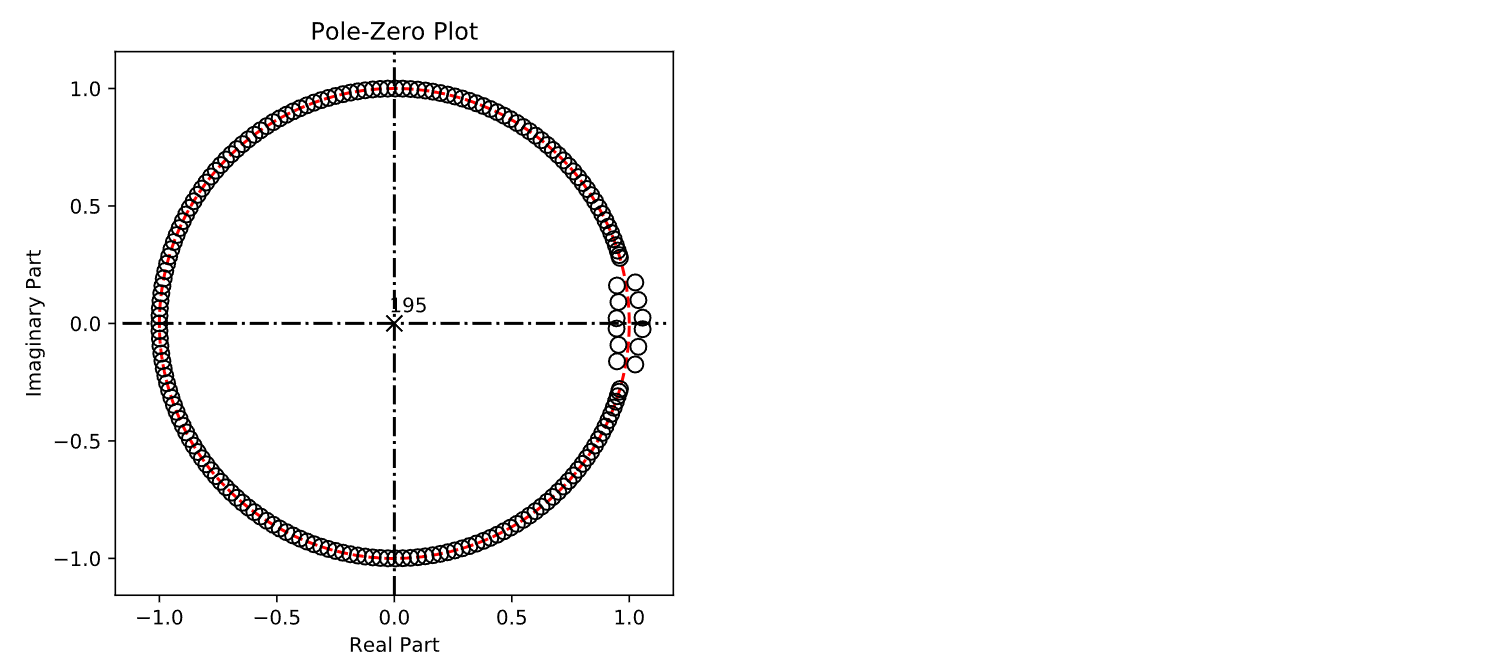

* Periksa penguatan pada jalur passband dan stopband.

In [ ]:
# Verify the passband and stopband gains are as expected
mr_up.freq_resp('db',96000)

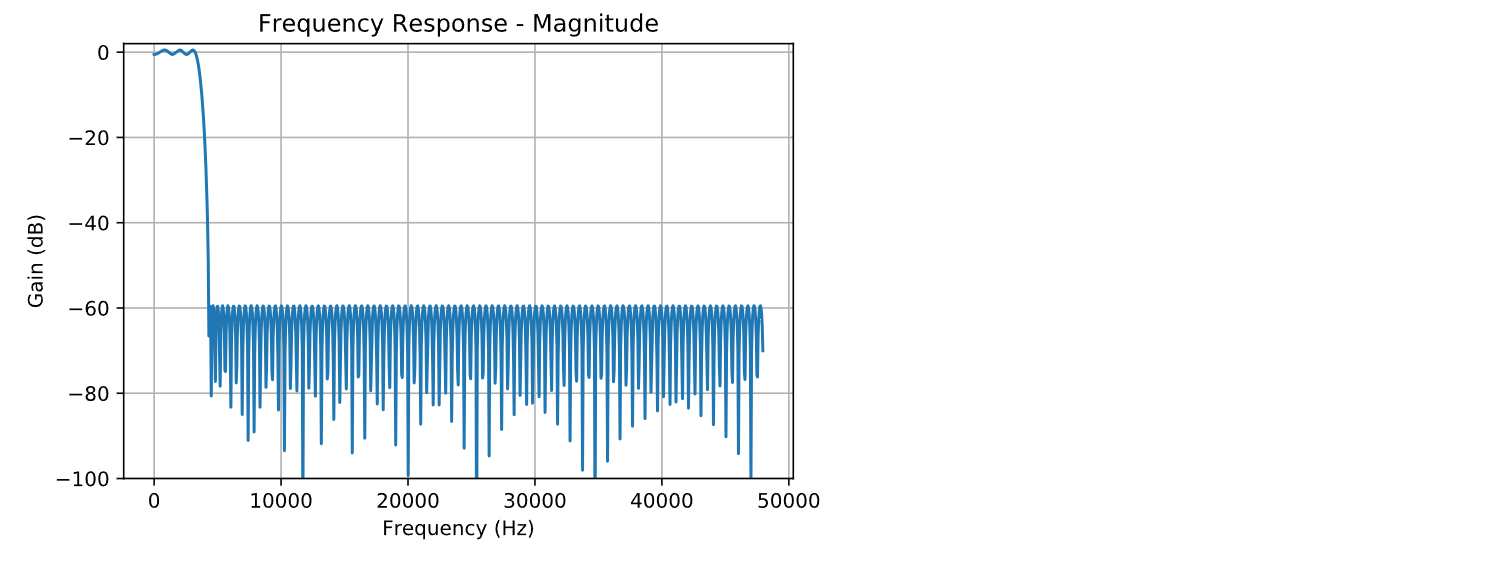

* Perhatikan bahwa delay grup adalah nilai yang diharapkan dari $(N_\text{taps} - 1)/2 = 98$ sampel.

In [ ]:
(len(b_up-1))/2

In [ ]:
# Verify that the FIR design has constant group delay (N_taps - 1)/2 samples
mr_up.freq_resp('groupdelay_s',96000,[0,100])

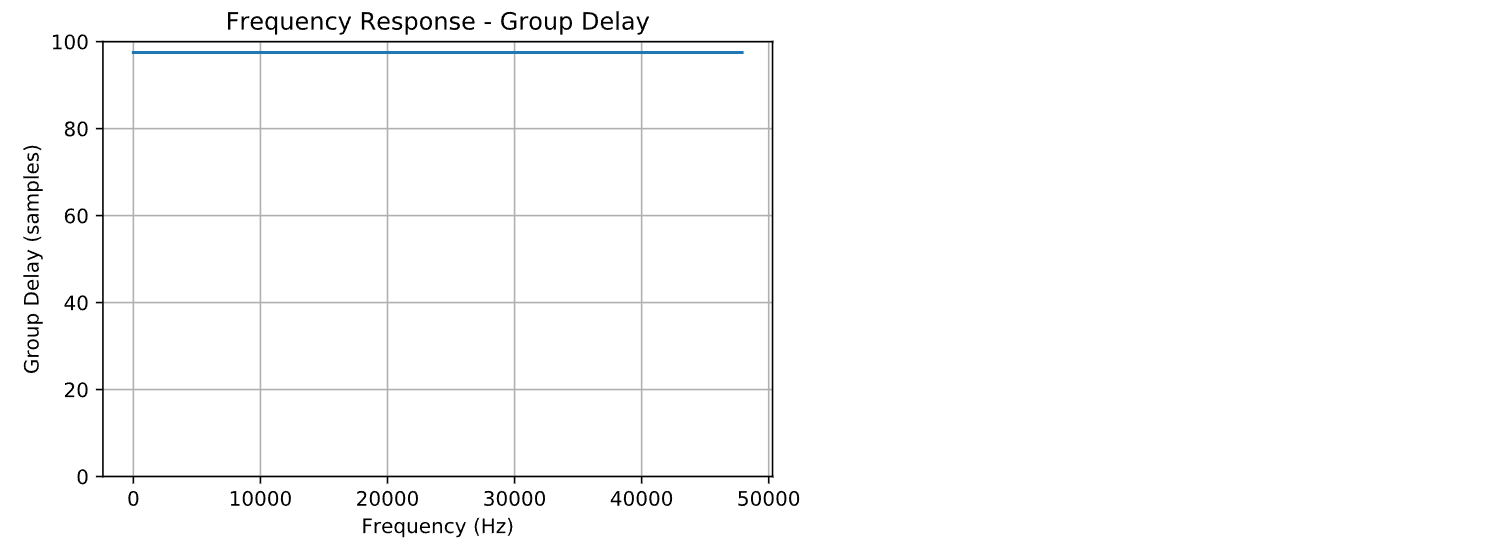

Objek mr_up sekarang dapat digunakan untuk interpolasi atau desimasi dengan faktor perubahan laju sebesar 12.

# Desain Filter IIR Tradisional Menggunakan Bilinear Transform
Paket scipy.signal sepenuhnya mendukung desain filter digital IIR dari prototipe analog. Filter IIR seperti filter FIR, biasanya dirancang dengan mempertimbangkan persyaratan respons amplitudo. Sejumlah fungsi desain tersedia langsung dari scipy.signal untuk tujuan ini, khususnya fungsi scipy.signal.iirdesign(). Untuk membuat desain filter lowpass, highpass, bandpass, dan bandstop konsisten dengan modul fir_design_helper.py, modul iir_design_helper.py ditulis. Gambar 2, di bawah ini, menjelaskan bagaimana parameter respons amplitudo didefinisikan secara grafis.

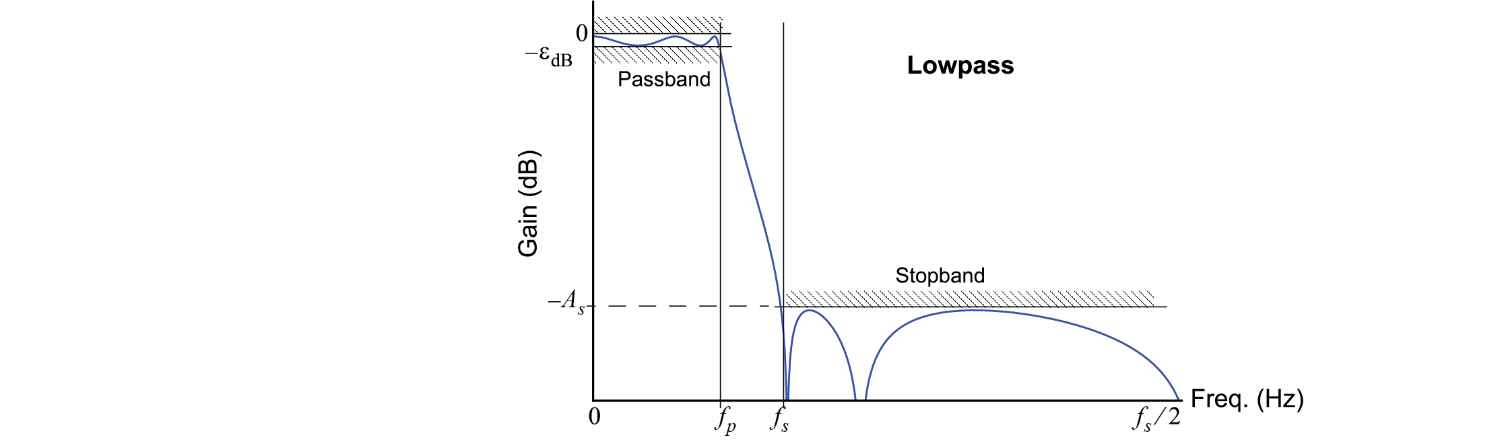

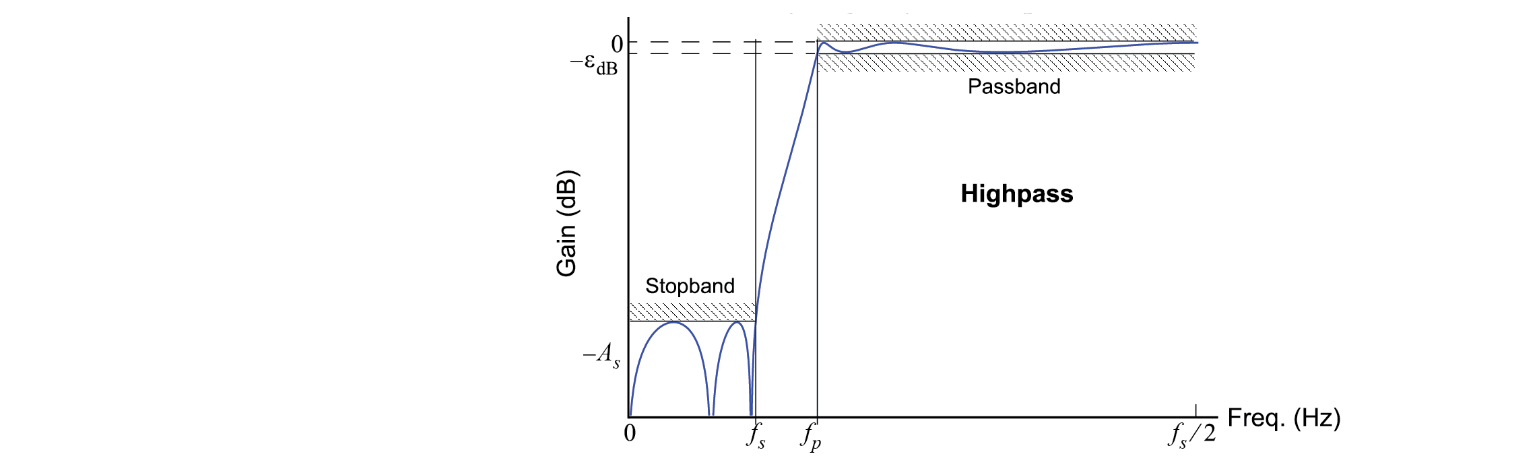

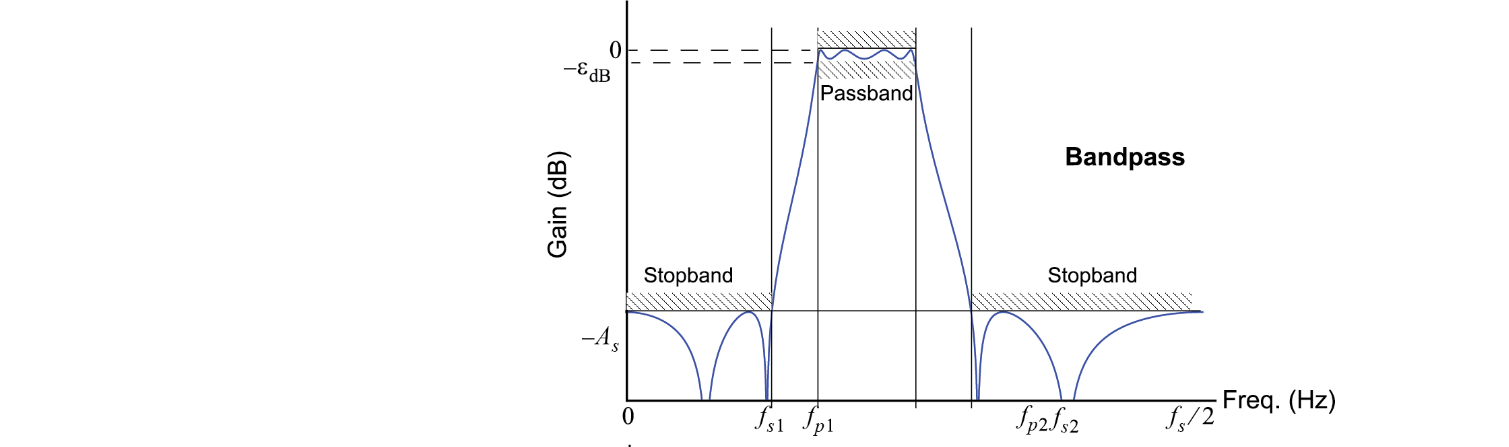

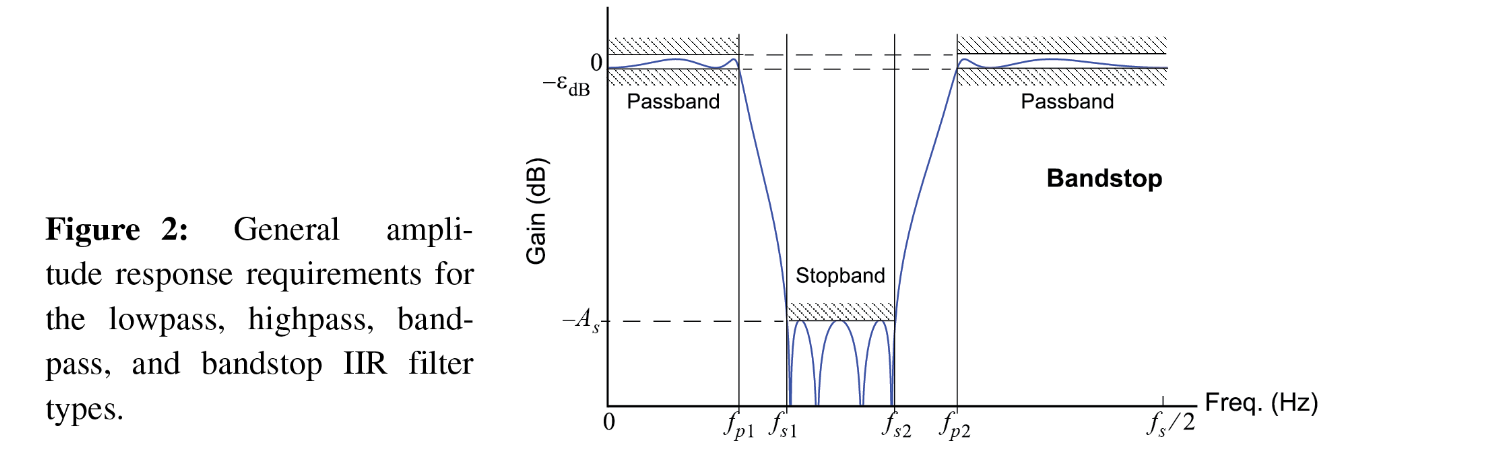

Di dalam iir_design_helper.py, terdapat empat fungsi desain filter dan sejumlah fungsi pendukung yang tersedia. Keempat fungsi desain filter tersebut digunakan untuk merancang filter lowpass, highpass, bandpass, dan bandstop, dengan memanfaatkan prototipe filter Butterworth, Chebyshev tipe 1, Chebyshev tipe 2, dan eliptikal. untuk informasi desain yang lebih detail. Antarmuka fungsi tersebut dijelaskan dalam Tabel 2.

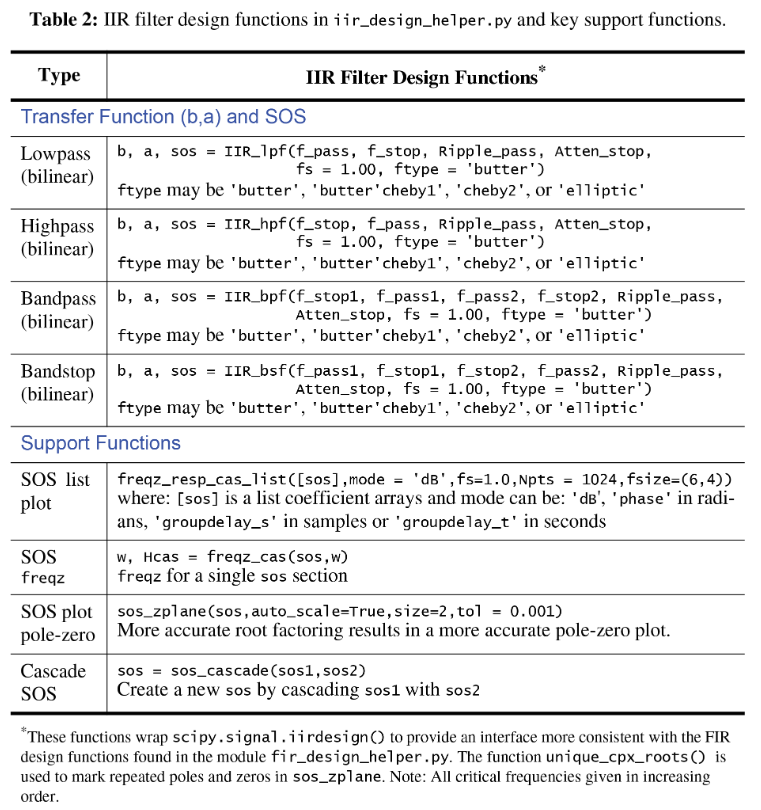

Fungsi filter mengembalikan koefisien filter dalam dua format:

1. Dalam bentuk fungsi transfer tradisional sebagai array koefisien pembilanbb` dan koefisien penyebu a`, dan
2. Dalam bentuk rangkaian dari bagian biquadratic menggunakan matriks atau array sos yang sebelumnya diperkenalkan.

Kedua format disediakan untuk memungkinkan analisis lebih lanjut dengan topologi bentuk langsung atau bentuk sos. Fugsi `signal.iirdesgn()` yang mendasarinya juga menyediakan opsi ketiga: daftar pole dan zero. Betuk`sos` diinginkan untuk filter presisi tinggi, karena lebih tahan terhadap kuantisasi koefisien, meskipun menggunakan koefisien presisi ganda dalam ary `b`dn `a`.

Dari fungsi pendukung yang tersisa, empat juga dijelaskan dalam Tabel 2 di atas. Fungsi yang paling signifikan dalah `freqz_resp_cs_list`, yang tersedia untuk membandingkan respons frekuensi secara grafis di beberapa desai, dan `soszplane` sebuah fungsi untuk memplot pola pole-zero. Keduanya beroperasi menggunakan mtris `sos`. Sebuah bentuk fungsi tr(sfe (`b/a`) untuk memplot respons frekensi, `freqz_rep_list`, juga ada dalam modul ini. Fungsi ini pertama kali diperkenalkan dalam bagian desain FIR. Fungsi plotting respons frekuensi menawarkan mode untuk gain dalam dB, fase dalam radian, delay grup dalam sampel, dan delay grup dalam detik, semua untuk sampling rate tertentu dalam Hz yang diberikan. Fungsi plotting pole-zero mengidentifikasi pole dan zero dengan lebih akurat daipada `sk_dsp_commsigsyszplane`, karena fungsinumpy `oots()` hanya menyelesaikan polinomial kuadrat. Juga, akar berulang dapat ditampilkan seperti yang diharapkan secara teoretis, dan juga diperhatikan dalam tampilan grafis dengan superskrip di samping penanda pole dan zero.

## Desain IIR Berdasarkan Transformasi Bilinear
Ada beberapa cara untuk merancang filter IIR berdasarkan persyaratan respons amplitudo. Ketika keinginan adalah agar aproksimasi filter mengikuti prototipe analog seperti Butterworth, Chebychev, dll., menggunakan transformasi bilinear. Fungsi signal.iirdesign() yang dijelaskan di atas melakukan hal ini dengan tepat.

Dalam contoh di bawah ini, kita pertimbangkan persyaratan respons amplitudo lowpass dan melihat bagaimana urutan filter berubah saat kita memilih prototipe analog yang berbeda.

### Contoh: Perbandingan Desain Lowpass
Persyaratan respons amplitudo lowpass dengan $f_s = 48$ kHz adalah:
1. $f_\text{pass} = 5$ kHz
2. $f_\text{stop} = 8$ kHz
3. Ripple passband sebesar 0.5 dB
4. Attenuasi stopband sebesar 60 dB

Rancang empat filter untuk memenuhi persyaratan yang sama: butter, cheby1, cheby2, dan ellip:

In [ ]:
fs = 48000
f_pass = 5000
f_stop = 8000
b_but,a_but,sos_but = iir_d.IIR_lpf(f_pass,f_stop,0.5,60,fs,'butter')
b_cheb1,a_cheb1,sos_cheb1 = iir_d.IIR_lpf(f_pass,f_stop,0.5,60,fs,'cheby1')
b_cheb2,a_cheb2,sos_cheb2 = iir_d.IIR_lpf(f_pass,f_stop,0.5,60,fs,'cheby2')
b_elli,a_elli,sos_elli = iir_d.IIR_lpf(f_pass,f_stop,0.5,60,fs,'ellip')

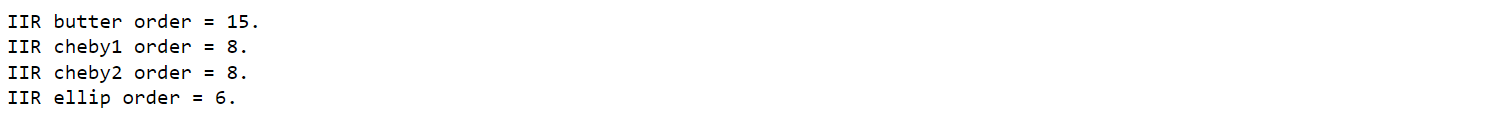

#### Perbandingan Respons Frekuensi
Di sini kita membandingkan respons magnitudo dalam dB menggunakan bentuk`so` dari masing-masing filter sebagai input. Filter eliptikal adalah yang paling efisien, dan bahkan berhasil melebihi persyaratan stopband dengan mencapai kurang dari 8 kHz.

In [ ]:
iir_d.freqz_resp_cas_list([sos_but,sos_cheb1,sos_cheb2,sos_elli],'dB',fs=48)
ylim([-80,5])
title(r'IIR Lowpass Compare')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Butter order: %d' % (len(a_but)-1),
        r'Cheby1 order: %d' % (len(a_cheb1)-1), 
        r'Cheby2 order: %d' % (len(a_cheb2)-1), 
        r'Elliptic order: %d' % (len(a_elli)-1)),loc='best')
grid();

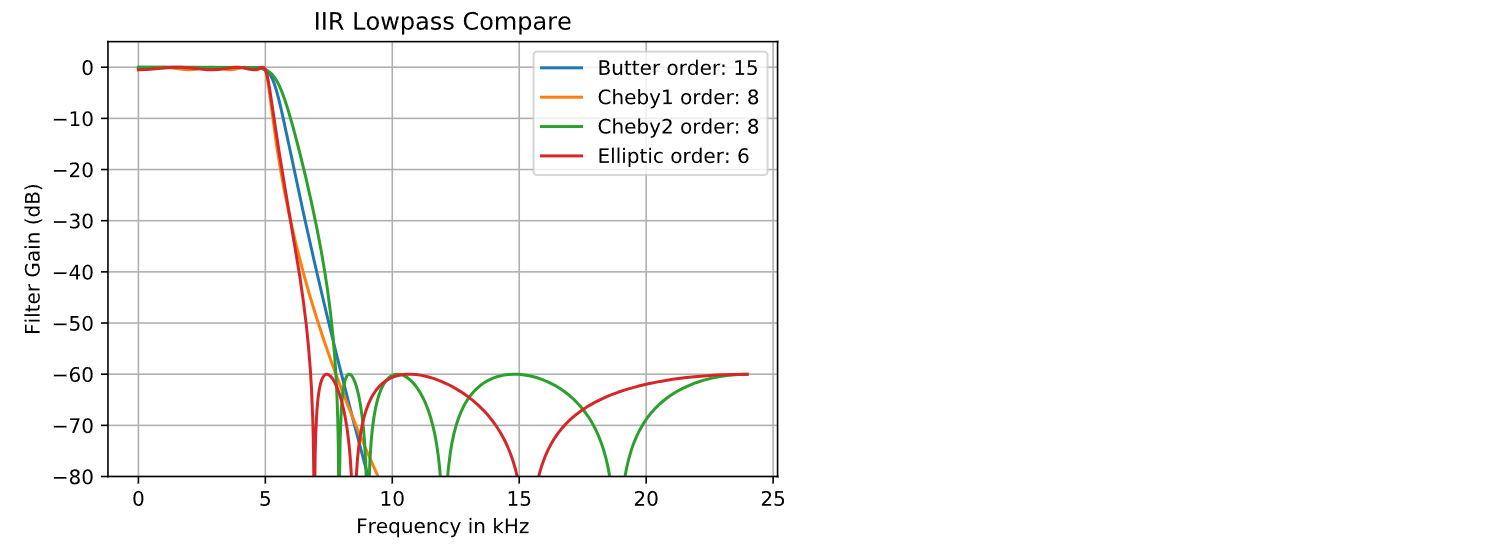

Selanjutnya, plot konfigurasi pole-zero dari desain butterworth saja. Di sini kita menggunakan versi khusus dari ss.zplane yang berfungsi dengan array 2D sos.

In [ ]:
iir_d.sos_zplane(sos_but)

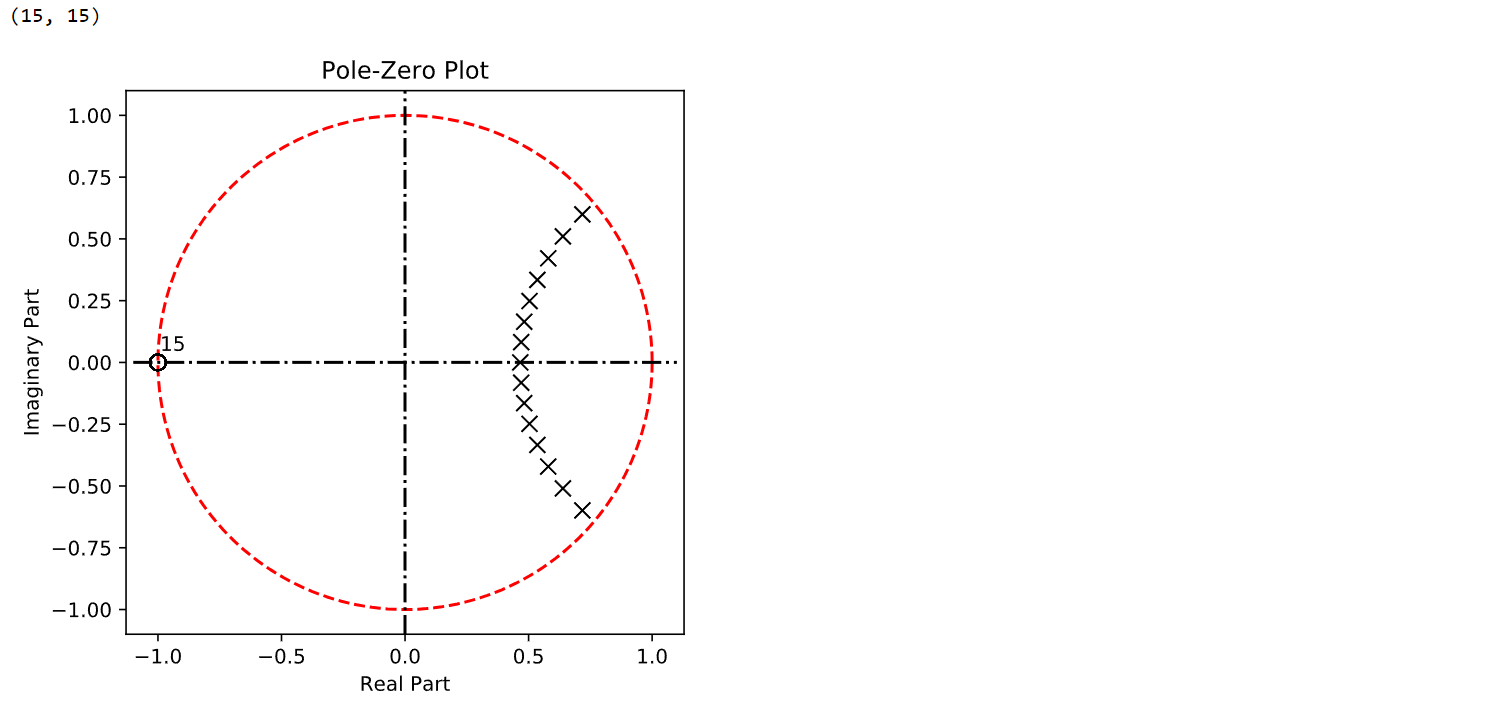

Catatan bahwa dua plot di atas juga dapat diperoleh menggunakan bentuk fungsi transfer melalui `iir_d.freqz_resp_list([b],[a],'dB',fs=48)` dan `ss.zplane(b,a)` masing-masing. Bentuk `sos` akan memberikan hasil yang lebih akurat, karena kurang sensitif terhadap kuantisasi koefisien. Hal ini terutama benar untuk plot pole-zero, karena merooting polinomial derajat ke-15 jauh lebih rentan terhadap kesalahan dibandingkan merooting polinomial kuadrat sederhana.

Untuk Butterworth orde ke-15, transformasi bilinear memetakan 15 nol domain-s ke tak hingga menjadi $z=-1$. Jika Anda menggunakan `sk_dsp_comm.sigsys.zplane()`, Anda akan menemukan bahwa 15 nol berada dalam lingkaran rapat di sekitar $z=-1$, menunjukkan kesalahan merooting polinomial. Demikian pula, respons frekuensi akan lebih akurat.

Pemfilteran sinyal dari array `x` dilakukan menggunakan desain filter dengan fungsi dari `scipy.signal`:

1. Untuk bentuk fungsi transfer `y = signal.lfilter(b,a,x)`
2. Untuk bentuk sos `y = signal.sosfilt(sos,x)`sos,x)`

## Desain Filter Half-Band untuk Melewati hingga $W/2$ saat $f_s = 8$ kHz
Di sini kita mempertimbangkan desain lowpass yang perlu melewati frekuensi hingga $f_s/4$. Secara khusus ketika $f_s = 8000$ Hz, passband filter menjadi [0, 2000] Hz. Setelah koefisien ditemukan, sebuah objek`mrh.multirat` diciptakan untuk memungkinkan studi lebih lanjut tentang filter, dan akhirnya menerapkan filtering dari sinyal white noise.

Mulailah dengan desain eliptikal yang memiliki transition band yang terpusat pada 2000 Hz dengan ripple passband sebesar 0.5 dB dan attenuasi stopband sebesar 80 dB. Bandwidth transisi diatur menjadi 100 Hz, dengan 50 Hz di setiap sisi dari 2000 Hz.

In [ ]:
# Elliptic IIR Lowpass
b_lp,a_lp,sos_lp = iir_d.IIR_lpf(1950,2050,0.5,80,8000.,'ellip')
mr_lp = mrh.multirate_IIR(sos_lp)

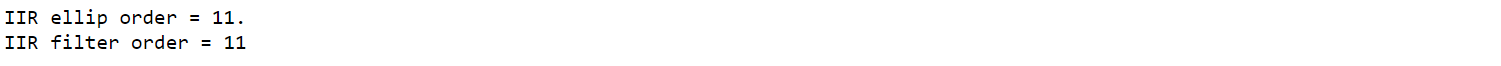

In [ ]:
mr_lp.freq_resp('db',8000)

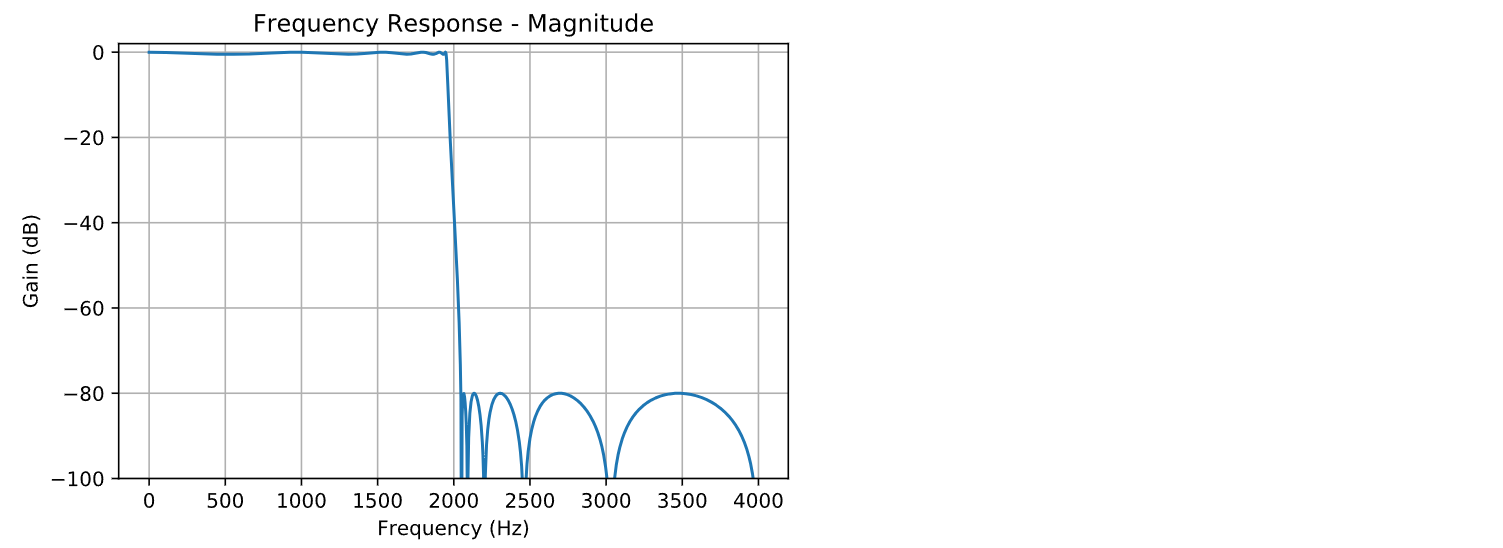

Lewatkan white noise Gaussian dengan varians $\sigma_x^2 = 1$ melalui filter. Gunakan banyak sampel sehingga estimasi spektral dapat membentuk dengan akurat $S_y(f) = \sigma_x^2\cdot |H(e^{j2\pi f/f_s})|^2 = |H(e^{j2\pi f/f_s})|^2$.

In [ ]:
x = randn(1000000)
y = mr_lp.filter(x)
psd(x,2**10,8000);
psd(y,2**10,8000);
title(r'Filtering White Noise Having $\sigma_x^2 = 1$')
legend(('Input PSD','Output PSD'),loc='best')
ylim([-130,-30])

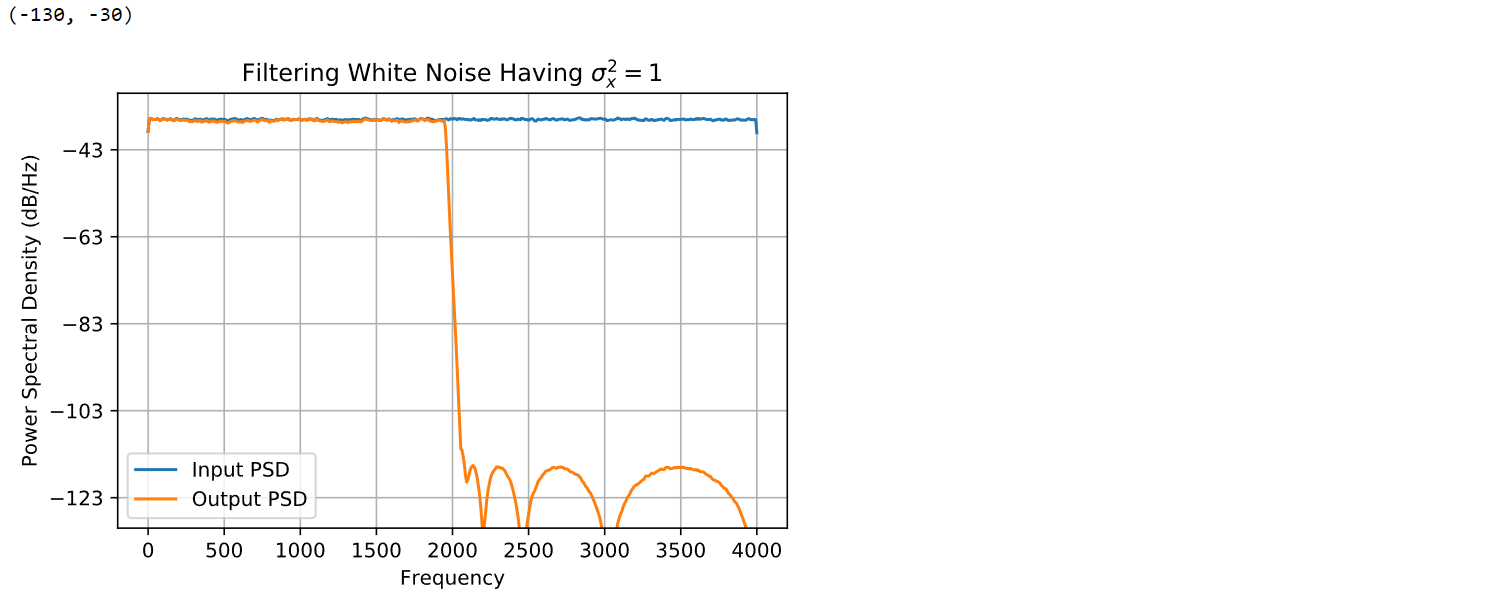

In [ ]:
fs = 8000
print('Expected PSD of %2.3f dB/Hz' % (0-10*log10(fs),))

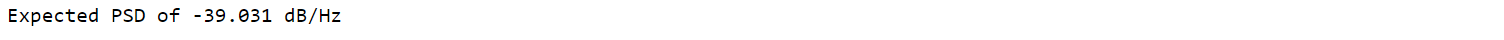

## Desain Bandpass Respons Amplitudo
Di sini kita pertimbangkan desain bandpass FIR dan IIR untuk digunakan dalam demodulator SSB untuk menghapus sinyal saluran sebelah yang mungkin berada di kedua sisi dari sebuah pita frekuensi yang berjalan dari 23 kHz hingga 24 kHz.

In [ ]:
b_rec_bpf1 = fir_d.fir_remez_bpf(23000,24000,28000,29000,0.5,70,96000,8)
fir_d.freqz_resp_list([b_rec_bpf1],[1],mode='dB',fs=96000)
ylim([-80, 5])
grid();

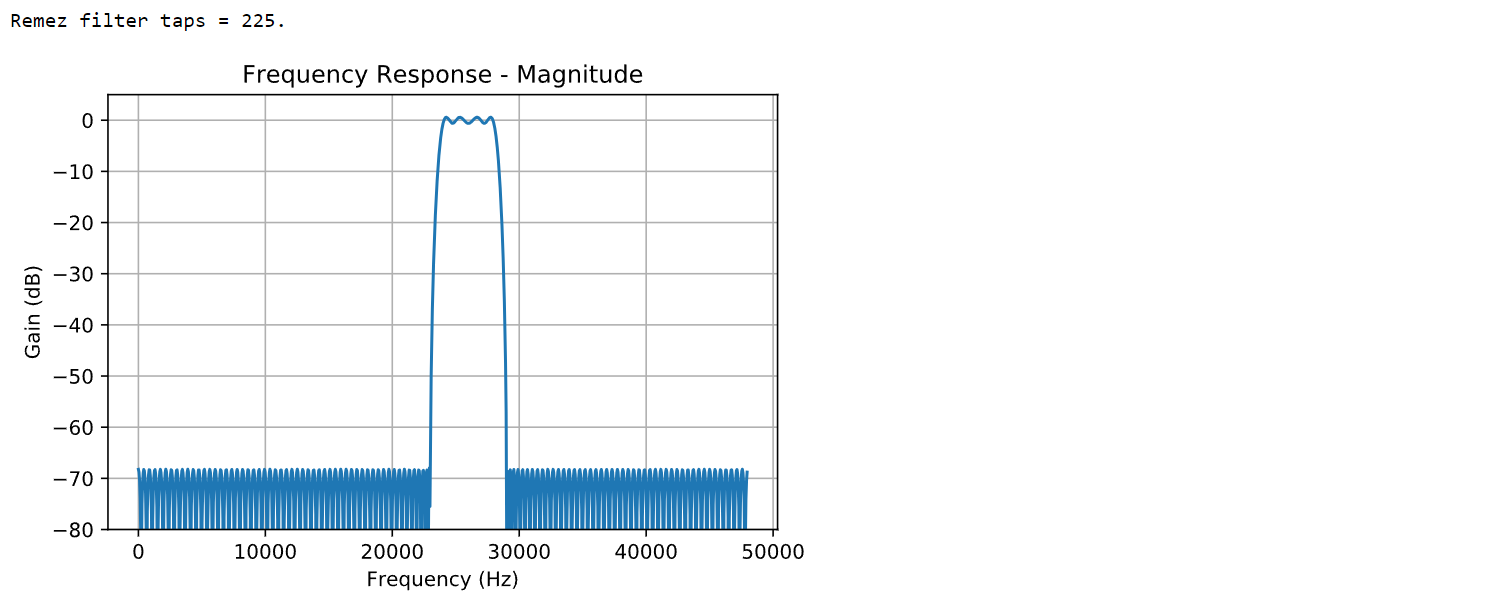

Delay grup datar (konstan) karena desain memiliki fase linear.

In [ ]:
b_rec_bpf1 = fir_d.fir_remez_bpf(23000,24000,28000,29000,0.5,70,96000,8)
fir_d.freqz_resp_list([b_rec_bpf1],[1],mode='groupdelay_s',fs=96000)
grid();

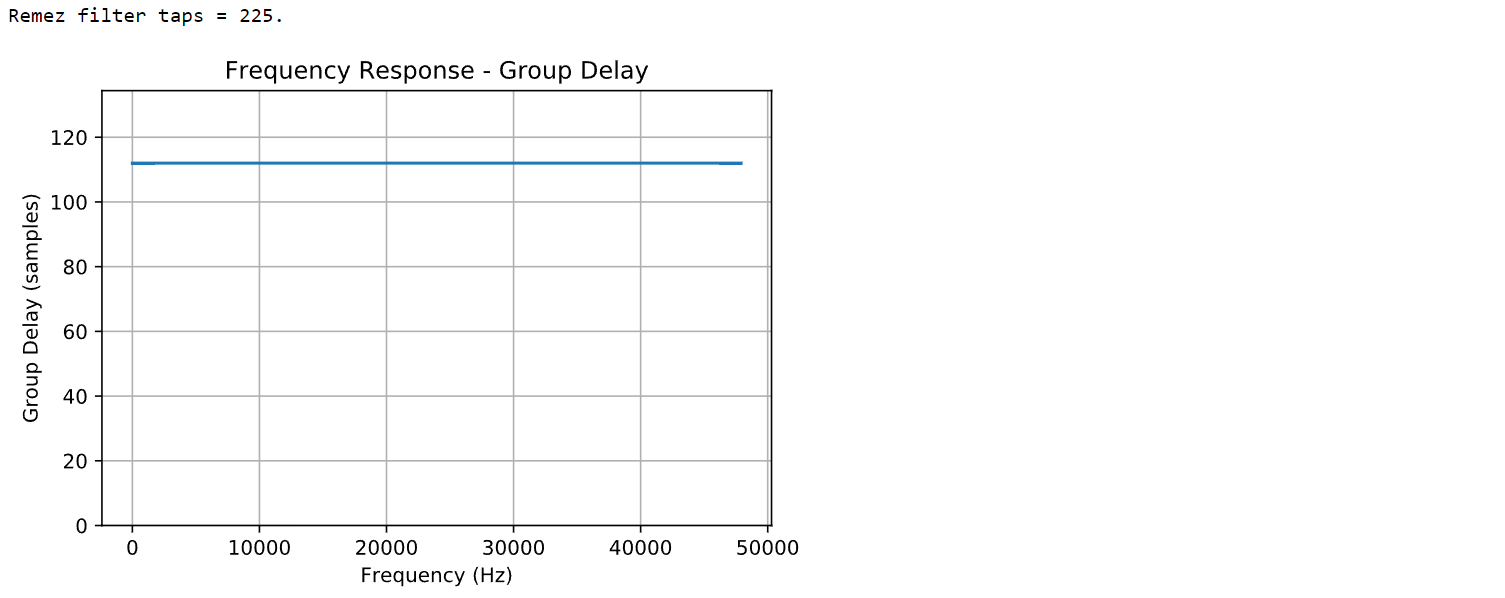

Bandingkan desain FIR dengan desain eliptikal:

In [ ]:
b_rec_bpf2,a_rec_bpf2,sos_rec_bpf2 = iir_d.IIR_bpf(23000,24000,28000,29000,
                                                   0.5,70,96000,'ellip')
with np.errstate(divide='ignore'):
    iir_d.freqz_resp_cas_list([sos_rec_bpf2],mode='dB',fs=96000)
ylim([-80, 5])
grid();

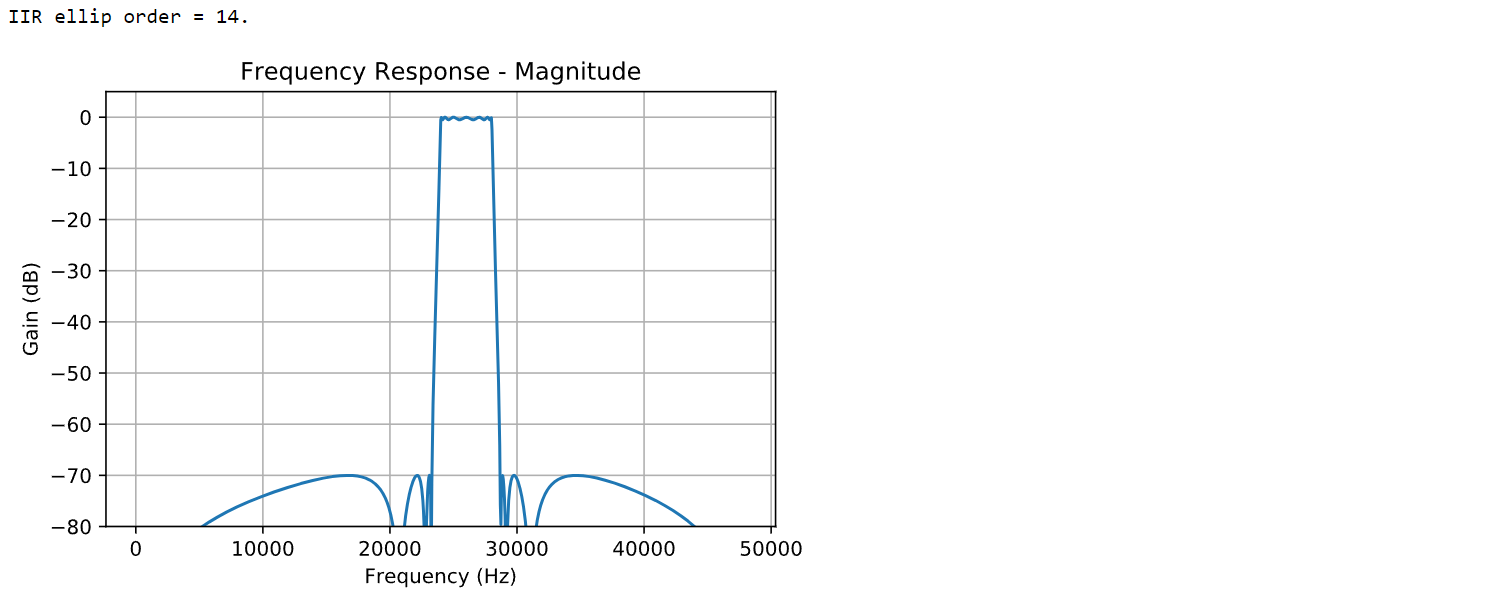

Elliptical orde tinggi ini memiliki respons amplitudo yang bagus dan rapat untuk jumlah koefisien minimal, tetapi delay grupnya buruk:

In [ ]:
with np.errstate(divide='ignore', invalid='ignore'): #manage singularity warnings
    iir_d.freqz_resp_cas_list([sos_rec_bpf2],mode='groupdelay_s',fs=96000)
#ylim([-80, 5])
grid();

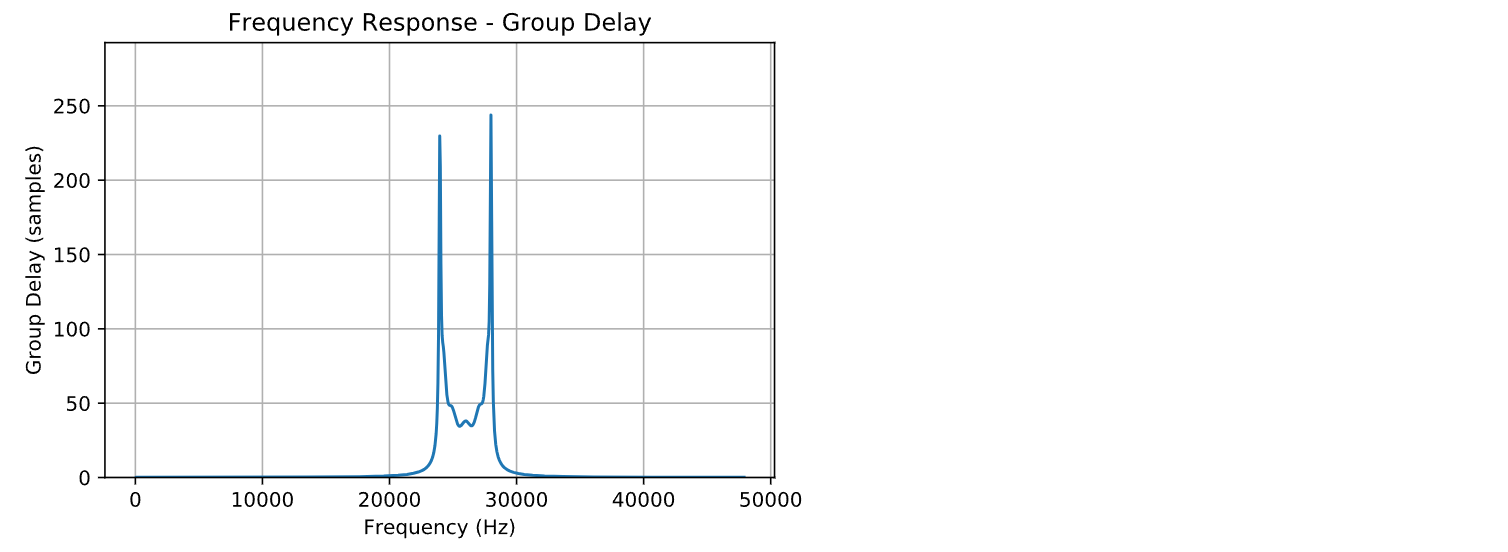